In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import sympy as sp
import fcs_demo as fcs
import time

In [2]:
size = 1
contrast_values = np.linspace(0.05, 0.25, size) 
counts_values = np.linspace(50.0, 51.0, 1)
FWHM_values = np.linspace(0.001, 0.01, size) #GHz

time = np.linspace(0.0, 5e04, 5001)
x_range = np.linspace(2.7, 3.0, time.size) #GHz
tau = np.linspace(50, 51, 1) #us
amp = np.linspace(0.5, 1.5, 1)
frequency = 0.2

mag_field_arrays, noisy_mag_field_arrays, odmr_spectrum_array, noisy_odmr_spectrum_array, noise_odmr_spectrum_array, noise_noisy_odmr_spectrum_array, rms_values, difference_values = fcs.arrays(amp, tau, time, contrast_values, counts_values, FWHM_values, x_range)

In [3]:
itr = 1000
w_1 = []
w_2 = []


noisy_mag_field_arrays = np.zeros((tau.size, amp.size, itr, x_range.size))
noisy_w_1 = [[] for _ in range(itr)]
noisy_w_2 = [[] for _ in range(itr)]


for m, contrast in enumerate(contrast_values):
    for j, counts in enumerate(counts_values):
        for k, FWHM in enumerate(FWHM_values):
            for i, a in enumerate(amp):
                for p, T in enumerate(tau):
                    noisy_mag_field_itr = []
                    for w in range(itr):
                        scaling = 1*np.array([np.exp(-t/T) for t in time])
                        white_noise = np.random.normal(size=time.size)

                        noisy_mag_field = 0.1*fcs.noisy_magnetic_field(white_noise, scaling) + 20
                        noisy_mag_field_itr.append(noisy_mag_field)
                        
                        noisy_mag_field_arrays[i, p, w, :] = noisy_mag_field
                        

                        for n, B_noise in enumerate(noisy_mag_field):
                            noisy_w1, noisy_w2 = fcs.frequencies(B_noise)

                            noisy_w_1[w].append(noisy_w1)
                            noisy_w_2[w].append(noisy_w2)
                            


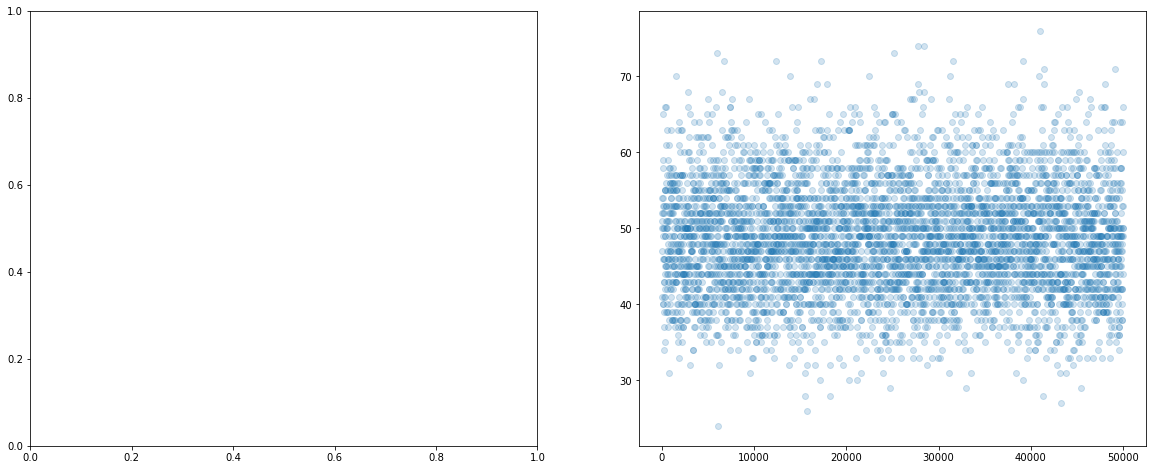

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=False, sharey=False)

# tracking_pos1 = [[] for _ in range(itr)]
# tracking_pos2 = [[] for _ in range(itr)]
# tracking_pos1 = np.zeros_like()


# max_slope_index_1, freq_point_of_max_slope_1 = fcs.derivative(x_range, FWHM, noisy_w2, FWHM, noisy_w2, contrast, counts)
# max_slope_index_2, freq_point_of_max_slope_2 = fcs.derivative(x_range, FWHM, noisy_w1, FWHM, noisy_w1, contrast, counts)

max_slope_index_1 = np.argmin(np.abs(x_range - (2814 - 0.6*0.5*1000*FWHM)/1000)) # we only want a fixed position - you can get an analytical expression for the point of maximum sensitivity for a lorentzian by looking at the second derivative
max_slope_index_2 = np.argmin(np.abs(x_range - (2814 - 0.6*0.5*1000*FWHM)/1000))
freq_1 = x_range[max_slope_index_1]
freq_2 = x_range[max_slope_index_2]


photon_trajectory = np.zeros((itr, time.size))


# freq_point_of_max_slope_1_array = np.linspace(freq_point_of_max_slope_1, freq_point_of_max_slope_1, time.size)

for i in range(contrast_values.size):
    for j in range(counts_values.size):
        for n in range(FWHM_values.size):
            for k in range(amp.size):
                for m in range(tau.size):
                    for z in range(itr):
                        noise_odmr_spectrum, noise_noisy_odmr_spectrum = fcs.simulate_ODMR(freq_1, 
                                                                                           FWHM, np.asarray(noisy_w_1[z]), FWHM, np.asarray(noisy_w_2[z]), contrast, counts) # you can pass the array directly to the function to avoid another nested loop
                                                                                                                                                                            # and we only need to calculate the count rate at one frequency
                        photon_trajectory[z,:] = np.asarray(noise_noisy_odmr_spectrum)

                        # for w1, w2 in zip(noisy_w_1[z], noisy_w_2[z]):
                            # noise_odmr_spectrum, noise_noisy_odmr_spectrum = fcs.simulate_ODMR(x_range, 
                                                   # FWHM, w1, FWHM, w2, contrast, counts)


                        # tracking_pos1[z].append(noise_noisy_odmr_spectrum[max_slope_index_1])
                        # tracking_pos2[z].append(noise_noisy_odmr_spectrum[max_slope_index_2])
                            
                        # axes[0].plot(x_range, noise_noisy_odmr_spectrum, '-*', alpha = 0.2)
                        # axes[0].set_xlim(2.805,2.825)
axes[1].plot(time,photon_trajectory[0,:], 'o', alpha = 0.2)

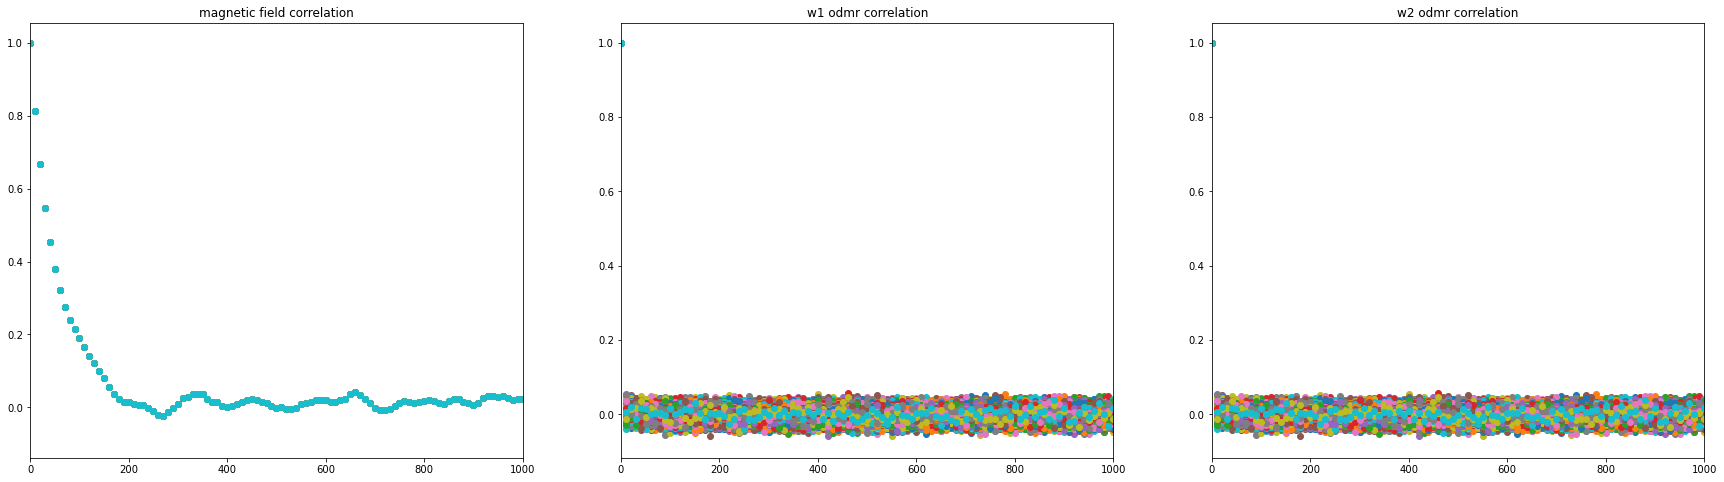

In [5]:
model = lm.models.ExponentialModel(prefix = 'e_')
pars = model.make_params()
pars['e_amplitude'].set(value = 1.0, min = 0.0, vary = False)
fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharex=True, sharey=False)

acf_norm_mag_array = []
acf_norm_odmr_array1 = []
acf_norm_odmr_array2 = []

for m, contrast in enumerate(contrast_values):
    for j, counts in enumerate(counts_values):
        for k, FWHM in enumerate(FWHM_values):
            for i, a in enumerate(amp):
                for p, T in enumerate(tau):
                    for w in range(itr):

                        autocorr_mag_data = np.zeros((amp.size*tau.size*contrast_values.size*counts_values.size*FWHM_values.size, white_noise.shape[0]))
                        autocorr_odmr_data1 = np.zeros((amp.size*tau.size*contrast_values.size*counts_values.size*FWHM_values.size, white_noise.shape[0]))
                        autocorr_odmr_data2 = np.zeros((amp.size*tau.size*contrast_values.size*counts_values.size*FWHM_values.size, white_noise.shape[0]))



                        noisy_mag_autocorr = fcs.autocorrelation(noisy_mag_field - np.mean(noisy_mag_field), time)
                        noisy_odmr_autocorr1 = fcs.autocorrelation(photon_trajectory[w]- np.mean(photon_trajectory[w]), time)
                        noisy_odmr_autocorr2 = fcs.autocorrelation(photon_trajectory[w]- np.mean(photon_trajectory[w]), time)



                        autocorr_mag_data[i*j*m*k*i*p,:] = noisy_mag_autocorr
                        autocorr_odmr_data1[i*j*m*k*i*p,:] = noisy_odmr_autocorr1
                        autocorr_odmr_data2[i*j*m*k*i*p,:] = noisy_odmr_autocorr2


                        acf_norm_mag = np.mean(autocorr_mag_data,0)/np.mean(autocorr_mag_data,0)[0]
                        acf_norm_odmr1 = np.mean(autocorr_odmr_data1,0)/np.mean(autocorr_odmr_data1,0)[0]
                        acf_norm_odmr2 = np.mean(autocorr_odmr_data2,0)/np.mean(autocorr_odmr_data2,0)[0]


                        acf_norm_mag_array.append(acf_norm_mag)
                        acf_norm_odmr_array1.append(acf_norm_odmr1)
                        acf_norm_odmr_array2.append(acf_norm_odmr2)



                        pars['e_decay'].set(value = tau[p], min = 0.0)

                        # noisy_mag_autocorr_fit = model.fit(acf_norm_mag, x = time, params = pars)
                        # noisy_odmr_autocorr_fit1 = model.fit(acf_norm_odmr1, x = time, params = pars)
                        # noisy_odmr_autocorr_fit2 = model.fit(acf_norm_odmr2, x = time, params = pars)



                        # axes[0].plot(time, noisy_mag_autocorr_fit.best_fit, '--', label = f"Fit, T_fit={noisy_mag_autocorr_fit.params['e_decay'].value:.3f}, \n T_char={tau[p]:.3f}")
                        axes[0].plot(time, acf_norm_mag, 'o', label = f'Corr, T_char={tau[m]:.3f}')
                        axes[0].set_title('magnetic field correlation')
                        # axes[0].legend() 

                        # axes[1].plot(time, noisy_odmr_autocorr_fit1.best_fit, '--', label = f"Fit, T_fit={noisy_odmr_autocorr_fit1.params['e_decay'].value:.3f}, \n T_char={tau[p]:.3f}")
                        axes[1].plot(time, acf_norm_odmr1, 'o', label = f'Corr, T_char={tau[m]:.3f}')
                        axes[1].set_title('w1 odmr correlation')
                        # axes[1].legend() 
                        
                        # axes[2].plot(time, noisy_odmr_autocorr_fit2.best_fit, '--', label = f"Fit, T_fit={noisy_odmr_autocorr_fit2.params['e_decay'].value:.3f}, \n T_char={tau[p]:.3f}")
                        axes[2].plot(time, acf_norm_odmr2, 'o', label = f'Corr, T_char={tau[m]:.3f}')
                        axes[2].set_title('w2 odmr correlation')
                        # axes[2].legend()  
    
                    axes[1].set_xlim(0,1000)

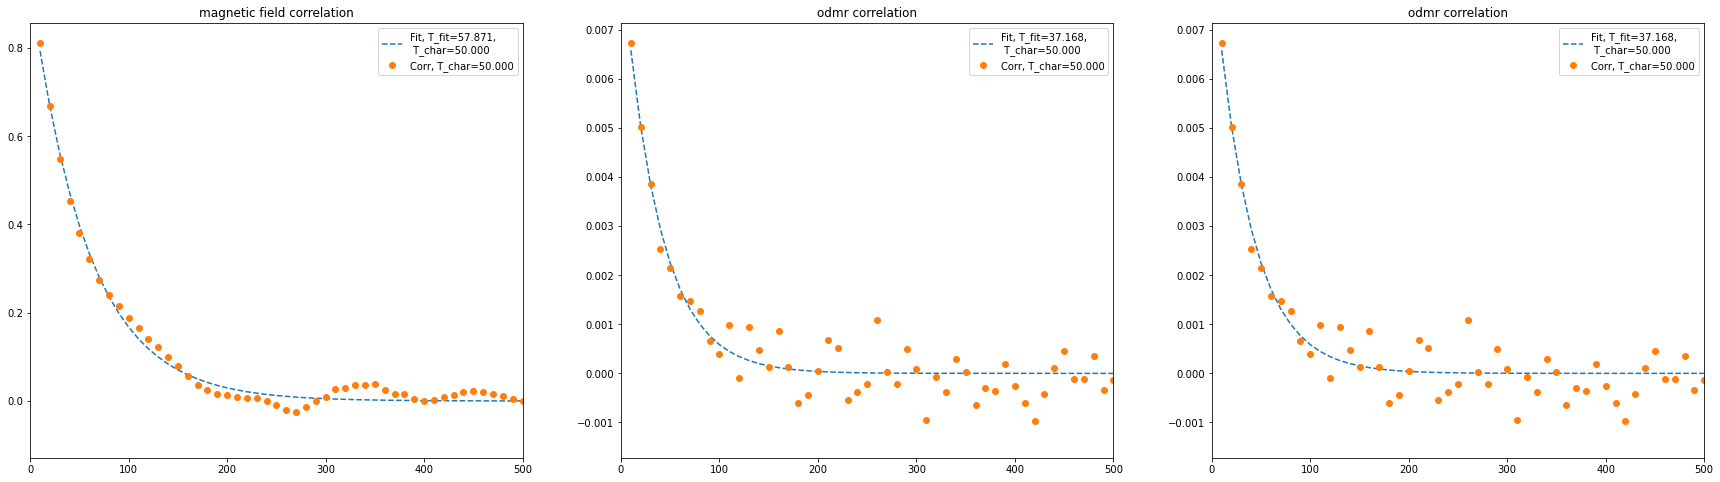

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharex=True, sharey=False)

stacked_mag_arrays = np.stack(acf_norm_mag_array, axis=0)
average_mag_array = np.mean(stacked_mag_arrays, axis=0)

stacked_odmr_arrays1 = np.stack(acf_norm_odmr_array1, axis=0)
average_odmr_array1 = np.mean(stacked_odmr_arrays1, axis=0)

stacked_odmr_arrays2 = np.stack(acf_norm_odmr_array2, axis=0)
average_odmr_array2 = np.mean(stacked_odmr_arrays2, axis=0)

model = lm.models.ExponentialModel(prefix = 'e_')
pars = model.make_params()
pars['e_amplitude'].set(value = 1.0, min = 0.0, vary = True)
for p, T in enumerate(tau):
    pars['e_decay'].set(value = tau[p], min = 0.0)
    avg_noisy_mag_autocorr_fit = model.fit(average_mag_array[1:], x = time[1:], params = pars)
    avg_noisy_odmr_autocorr_fit1 = model.fit(average_odmr_array1[1:], x = time[1:], params = pars)
    avg_noisy_odmr_autocorr_fit2 = model.fit(average_odmr_array2[1:], x = time[1:], params = pars)


    axes[0].plot(time[1:], avg_noisy_mag_autocorr_fit.best_fit, '--', label = f"Fit, T_fit={avg_noisy_mag_autocorr_fit.params['e_decay'].value:.3f}, \n T_char={tau[p]:.3f}")
    axes[0].plot(time[1:], average_mag_array[1:], 'o', label = f'Corr, T_char={tau[m]:.3f}')
    axes[0].set_title('magnetic field correlation')
    axes[0].legend()
    
    axes[1].plot(time[1:], avg_noisy_odmr_autocorr_fit1.best_fit, '--', label = f"Fit, T_fit={avg_noisy_odmr_autocorr_fit1.params['e_decay'].value:.3f}, \n T_char={tau[p]:.3f}")
    axes[1].plot(time[1:], average_odmr_array1[1:], 'o', label = f'Corr, T_char={tau[m]:.3f}')
    axes[1].set_title('odmr correlation')
    axes[1].legend()
    
    axes[2].plot(time[1:], avg_noisy_odmr_autocorr_fit2.best_fit, '--', label = f"Fit, T_fit={avg_noisy_odmr_autocorr_fit2.params['e_decay'].value:.3f}, \n T_char={tau[p]:.3f}")
    axes[2].plot(time[1:], average_odmr_array2[1:], 'o', label = f'Corr, T_char={tau[m]:.3f}')
    axes[2].set_title('odmr correlation')
    axes[2].legend()
    
    axes[2].set_xlim(0,500)